
# ENEL 645 Assignment 2

### Stephen Moore, Winter 2025

Imports:

In [1]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Set device; check if GPU is available

print("Device: ", device) 

Device:  cpu


Paths:

In [3]:
TRAIN_PATH = f"/work/souza_lab/garbage_data/CVPR_2024_dataset_Train"
VAL_PATH = f"/work/souza_lab/garbage_data/CVPR_2024_dataset_Val"
TEST_PATH = f"/work/souza_lab/garbage_data/CVPR_2024_dataset_Test"

Dataset information for images:

In [4]:
# Transforms 
torchvision_transform = transforms.Compose([transforms.Resize((224,224)),\
    transforms.RandomHorizontalFlip(), transforms.RandomVerticalFlip(),
    transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406] ,std=[0.229, 0.224, 0.225] )])


torchvision_transform_test = transforms.Compose([transforms.Resize((224,224)),\
    transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406] ,std=[0.229, 0.224, 0.225])])

Dataset information for text:

In [4]:
from transformers import DistilBertTokenizer

# Tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Tokenize data
max_len = 24

Full combined dataset and dataset example:

In [ ]:
from Datasets.Dataset import GarbageDataset # Custom made dataset, built on top of ImageFolder

train_dataset = GarbageDataset(
    root = TRAIN_PATH, tokenizer = tokenizer, max_len = max_len, transform = torchvision_transform, 
)

In [10]:
class_names = train_dataset.classes
print(class_names)

['Black', 'Blue', 'Green', 'TTR']


In [7]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [8]:
train_iterator = iter(train_dataloader)
train_batch = next(train_iterator)

print(train_batch.keys())


dict_keys(['image', 'text', 'input_ids', 'attention_mask', 'label'])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


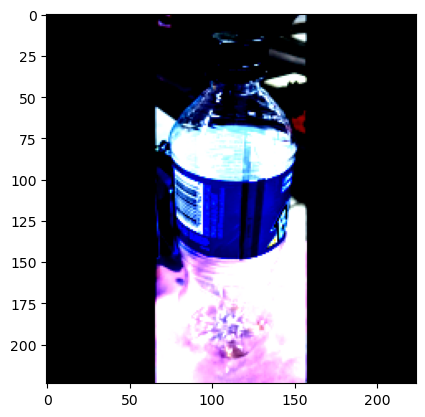

ice tea plastic bottle 
tensor(1)
tensor([ 101, 3256, 5572, 6081, 5835,  102,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0])


In [9]:
plt.imshow(train_batch['image'][8].permute(1, 2, 0))
plt.show()
print(train_batch['text'][8])
print(train_batch['label'][8])
print(train_batch['input_ids'][8])

In [8]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from transformers import DistilBertTokenizer

from Model.FusionModel import FusionModel
from Datasets.Dataset import GarbageDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Set device; check if GPU is available

print(f'Device: {device}', flush = True) 

TEST_PATH = f"/work/souza_lab/garbage_data/CVPR_2024_dataset_Test"

# Define transformation, datasets, and batch size / num workers - from tutorials
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image to PyTorch tensor
])


# Tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
max_len = 24

# Load Datasets
test_dataset = GarbageDataset(
    root = TEST_PATH, tokenizer = tokenizer, max_len = max_len, transform = transform
)

# Define batch size and number of workers (adjust as needed)
batch_size = 16
num_workers = 4

# Create data loaders
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True, num_workers = num_workers)

PATH = './garbage_net.pth'


model = FusionModel(
    num_classes = 4,
    image_input_shape = (3,224,224), 
    transfer = False)
model.load_state_dict(torch.load(PATH, map_location=torch.device('cpu')))  # Load weights
model.eval()  # Set model to evaluation mode

correct = 0
total = 0

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data['image'], data['label']
        input_ids, attention_mask = data['input_ids'], data['attention_mask']

        outputs = model(inputs, input_ids, attention_mask)

        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct / total} %')

Device: cpu


/home/stephen.moore/anaconda3/envs/mdsc508_dev/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


RuntimeError: DataLoader worker (pid(s) 1882960) exited unexpectedly